## Francesco Grimaldi

# 4.0) Multiple Classifcators with tf-idf

## Step 0: Importing the data and basic libraries

In [1]:
import numpy as np
import pandas as pd
import nltk
import warnings
warnings.filterwarnings("ignore")
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fgrim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Import Raw Data  

In [2]:
df = pd.read_json("op_spam_v1.4.json") ##file with all the data gathered togheter in a very nice way, provided by Arpad
df.head()

description                                               file  polarity  \
0    hilton_1  \negative_polarity\deceptive_from_MTurk\fold1\...     False   
1   hilton_10  \negative_polarity\deceptive_from_MTurk\fold1\...     False   
2   hilton_11  \negative_polarity\deceptive_from_MTurk\fold1\...     False   
3   hilton_12  \negative_polarity\deceptive_from_MTurk\fold1\...     False   
4   hilton_13  \negative_polarity\deceptive_from_MTurk\fold1\...     False   

                                                text  truth  
0  We stayed at the Schicago Hilton for 4 days an...  False  
1  Hotel is located 1/2 mile from the train stati...  False  
2  I made my reservation at the Hilton Chicago be...  False  
3  When most people think Hilton, they think luxu...  False  
4  My husband and I recently stayed stayed at the...  False

## Step 1: Data  pre-processing

Transform our data in something meaningful for our Deep Learning Classifier

### Data transformation

Transforming polarity and truth in 0 and 1, dropping path and description

In [3]:
df["truth"][df["truth"] == False], df["truth"][df["truth"] == True] = int(0), int(1)
df["polarity"][df["polarity"] == False], df["polarity"][df["polarity"] == True] = int(0), int(1)

df = df.drop(["file", "description"], axis=1)
columnsTitles=["truth","polarity", "text"]

df = df.reindex(columns=columnsTitles)
df.head()

truth  polarity                                               text
0    0.0       0.0  We stayed at the Schicago Hilton for 4 days an...
1    0.0       0.0  Hotel is located 1/2 mile from the train stati...
2    0.0       0.0  I made my reservation at the Hilton Chicago be...
3    0.0       0.0  When most people think Hilton, they think luxu...
4    0.0       0.0  My husband and I recently stayed stayed at the...

### Tokenization

Using nltk package in order to tokenize the documents. The tokenize methods separate punctuations so that: "word," goes to two token: "word" and ","

In [4]:
df["token"] = [nltk.word_tokenize(text) for text in df["text"]]
#df["token"] = df["token"].apply(lambda l: [x.lower() for x in l])
df.head()

truth  polarity                                               text  \
0    0.0       0.0  We stayed at the Schicago Hilton for 4 days an...   
1    0.0       0.0  Hotel is located 1/2 mile from the train stati...   
2    0.0       0.0  I made my reservation at the Hilton Chicago be...   
3    0.0       0.0  When most people think Hilton, they think luxu...   
4    0.0       0.0  My husband and I recently stayed stayed at the...   

                                               token  
0  [We, stayed, at, the, Schicago, Hilton, for, 4...  
1  [Hotel, is, located, 1/2, mile, from, the, tra...  
2  [I, made, my, reservation, at, the, Hilton, Ch...  
3  [When, most, people, think, Hilton, ,, they, t...  
4  [My, husband, and, I, recently, stayed, stayed...

### Removing Stop Words

Stop words are not informative words, such as: "at", "and", "or" etc...
For this reason we can remove them without compromizing our features

In [5]:
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))
stop_words.remove("no")
stop_words.remove("not")

df["no_StopWord_token"] = df["token"].apply(lambda l: [x for x in l if x not in stop_words])
print("Removing Stop-Words procedure: Done")

Removing Stop-Words procedure: Done


### Removing punctuations

In [6]:
puntk = set([".", ",", ":", "!", "?", '"', ";", "(", ")", "...", "''"])
df["no_StopWord_token"] = df["no_StopWord_token"].apply(lambda l: [x for x in l if x not in puntk])

In [7]:
text = df["no_StopWord_token"]
df[["truth", "polarity", "no_StopWord_token"]].head()

truth  polarity                                  no_StopWord_token
0    0.0       0.0  [We, stayed, Schicago, Hilton, 4, days, 3, nig...
1    0.0       0.0  [Hotel, located, 1/2, mile, train, station, qu...
2    0.0       0.0  [I, made, reservation, Hilton, Chicago, believ...
3    0.0       0.0  [When, people, think, Hilton, think, luxury, I...
4    0.0       0.0  [My, husband, I, recently, stayed, stayed, Hil...

In [8]:
sno = nltk.stem.SnowballStemmer('english')
df["no_StopWord_token"] = df["no_StopWord_token"].apply(lambda l: [sno.stem(x) for x in l])
df.head()

truth  polarity                                               text  \
0    0.0       0.0  We stayed at the Schicago Hilton for 4 days an...   
1    0.0       0.0  Hotel is located 1/2 mile from the train stati...   
2    0.0       0.0  I made my reservation at the Hilton Chicago be...   
3    0.0       0.0  When most people think Hilton, they think luxu...   
4    0.0       0.0  My husband and I recently stayed stayed at the...   

                                               token  \
0  [We, stayed, at, the, Schicago, Hilton, for, 4...   
1  [Hotel, is, located, 1/2, mile, from, the, tra...   
2  [I, made, my, reservation, at, the, Hilton, Ch...   
3  [When, most, people, think, Hilton, ,, they, t...   
4  [My, husband, and, I, recently, stayed, stayed...   

                                   no_StopWord_token  
0  [we, stay, schicago, hilton, 4, day, 3, night,...  
1  [hotel, locat, 1/2, mile, train, station, quit...  
2  [i, made, reserv, hilton, chicago, believ, i, ...  
3  [when, peopl, think, hilton, think, luxuri, i,...  
4  [my, husband, i, recent, stay, stay, hilton, c...

## Step 2: Bag of Words

Creating as a features for our classifier an input based on Bag of Words, with n-grams which go from 1 to 3. <br>

### Retransforming token in String

Some data pre-processing

In [9]:
text_wo_SW = []

for text in df["no_StopWord_token"]:
    text_wo_SW.append(" ".join(text))

df["text_without_SW"] = text_wo_SW
df[["truth", "polarity", "text_without_SW"]].head()

truth  polarity                                    text_without_SW
0    0.0       0.0  we stay schicago hilton 4 day 3 night confer i...
1    0.0       0.0  hotel locat 1/2 mile train station quit hike r...
2    0.0       0.0  i made reserv hilton chicago believ i go stay ...
3    0.0       0.0  when peopl think hilton think luxuri i know i ...
4    0.0       0.0  my husband i recent stay stay hilton chicago h...

### Creating DF of Bag Of Words and N-grams

tf-idf is used to calculate "the importance" of each n-gram in each document and then normalized by each row
<br> Furthermore n-gramm too much frequent or too less frequent are removed as they are not meaningful.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
texts = df["text_without_SW"]
tfidf = TfidfVectorizer(min_df = 3, max_df=0.5, ngram_range=(1, 2))
features = tfidf.fit_transform(texts)
print("'tf-idf procedure: Done'")

'tf-idf procedure: Done'


In [11]:
df_BoW = pd.DataFrame(features.todense(), columns=tfidf.get_feature_names())
df_BoW["truth"] = df["truth"]
df_BoW.head(5)

00  00 night  00 per  00 pm  000   10  10 10  10 15  10 30  10 day  ...   \
0  0.0       0.0     0.0    0.0  0.0  0.0    0.0    0.0    0.0     0.0  ...    
1  0.0       0.0     0.0    0.0  0.0  0.0    0.0    0.0    0.0     0.0  ...    
2  0.0       0.0     0.0    0.0  0.0  0.0    0.0    0.0    0.0     0.0  ...    
3  0.0       0.0     0.0    0.0  0.0  0.0    0.0    0.0    0.0     0.0  ...    
4  0.0       0.0     0.0    0.0  0.0  0.0    0.0    0.0    0.0     0.0  ...    

   you re  you take  young  young woman  younger  your  yuck  yummi  zest  \
0     0.0       0.0    0.0          0.0      0.0   0.0   0.0    0.0   0.0   
1     0.0       0.0    0.0          0.0      0.0   0.0   0.0    0.0   0.0   
2     0.0       0.0    0.0          0.0      0.0   0.0   0.0    0.0   0.0   
3     0.0       0.0    0.0          0.0      0.0   0.0   0.0    0.0   0.0   
4     0.0       0.0    0.0          0.0      0.0   0.0   0.0    0.0   0.0   

   zone  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0  

[5 rows x 9729 columns]

In [12]:
X = df_BoW.drop(['truth'], axis=1)
y = df_BoW['truth']

### Applying PCA

Applying the Principal Components Analysis to make the algorith speed up and clustering the enourmos quantity of features. The least variance the reduced model is the 95% of the original one

In [13]:
from sklearn.decomposition import PCA
pca = PCA(.95)
pca.fit(X)
X = pca.transform(X)
print("PCA has been completed")
print("Number of inputs: {}".format(np.shape(X)[1]))

PCA has been completed
Number of inputs: 1342


## Step 3: Different models

In [14]:
#from xgboost import XGBClassifier
#import xgboost

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import model_selection, svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC


In [15]:
%matplotlib inline
numeric_data = X
target = y
numeric_data_best = SelectKBest(f_classif, k=6).fit_transform(numeric_data, target)

Random Forest: Done
KNN: Done
Logistic: Done
Gradient Boosting: Done
SVC: Done


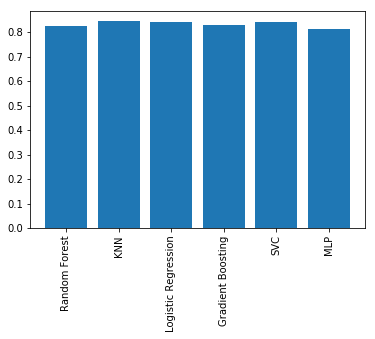

In [16]:
# Trying to find best model
model_rfc = RandomForestClassifier(n_estimators = 70)
model_knc = KNeighborsClassifier(n_neighbors = 18) 
model_lr = LogisticRegression(penalty='l1', tol=0.01) 
model_gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)
model_svc = svm.SVC() 
#model_xgb = XGBClassifier()
model_svc = SVC(kernel='rbf', random_state=0)

ROCtrainTRN, ROCtestTRN, ROCtrainTRG, ROCtestTRG = model_selection.train_test_split(numeric_data_best, target, test_size=0.25) 

results = {}
kfold = 5

results['Random Forest'] = model_selection.cross_val_score(model_rfc, numeric_data_best, target, cv=kfold).mean()
print("Random Forest: Done")
results['KNN'] = model_selection.cross_val_score(model_knc, numeric_data_best, target, cv=kfold).mean()
print("KNN: Done")
results['Logistic Regression'] = model_selection.cross_val_score(model_lr, numeric_data_best, target, cv = kfold).mean()
print("Logistic: Done")
results['Gradient Boosting'] = model_selection.cross_val_score(model_gb, numeric_data_best, target, cv = kfold).mean()
print("Gradient Boosting: Done")
results['SVC'] = model_selection.cross_val_score(model_svc, numeric_data_best, target, cv = kfold).mean()
print("SVC: Done")
#results['XGB'] = model_selection.cross_val_score(model_xgb, numeric_data_best, target, cv = kfold).mean()
#print("XGB: Done")

clf = MLPClassifier(solver='lbfgs', alpha=0.0001,
                    hidden_layer_sizes=(3, 25), random_state=42, learning_rate = 'adaptive')
results['MLP'] = model_selection.cross_val_score(clf, numeric_data, target, cv=kfold).mean()

plt.bar(range(len(results)), results.values(), align='center')
plt.xticks(range(len(results)), list(results.keys()), rotation='vertical')
plt.show()

## Step 4: Displaying ROC Curve

In [78]:
l = []
max_acc = 0
for i in range(3, 30):
    for j in range(3, 30):
        clf = MLPClassifier(solver='lbfgs', alpha=0.0001,
                    hidden_layer_sizes=(i, j), random_state=42, learning_rate = 'adaptive')
        acc_on_test = model_selection.cross_val_score(clf, numeric_data, target, cv=kfold).mean()
        l.append(model_selection.cross_val_score(clf, numeric_data, target, cv=kfold).mean())
        if acc_on_test > max_acc:
            max_acc = acc_on_test
            print("\nFound a new best architecture, now displaying results:")
            print("Neruons on 1st Layer: {}\nNeurons on 2nd layer: {}\nAccurancy on test: {}"
                  .format(i, j, acc_on_test))


Found a new best architecture, now displaying results:
Layer: 3
NeuronsOnLayer: 3
Accurancy on test: 0.884375

Found a new best architecture, now displaying results:
Layer: 3
NeuronsOnLayer: 4
Accurancy on test: 0.8856249999999999

Found a new best architecture, now displaying results:
Layer: 3
NeuronsOnLayer: 25
Accurancy on test: 0.889375


In [17]:
result_name = [x for x in results]
result_acc = [results[x] for x in results]
result_acc = np.round(result_acc, 2)
df_res = pd.DataFrame(result_acc, index = result_name, columns = ["Accuracy"])
df_res = df_res.transpose()
df_res.head()

df_res.to_csv("Models_accuracy.csv")

<Figure size 432x288 with 0 Axes>

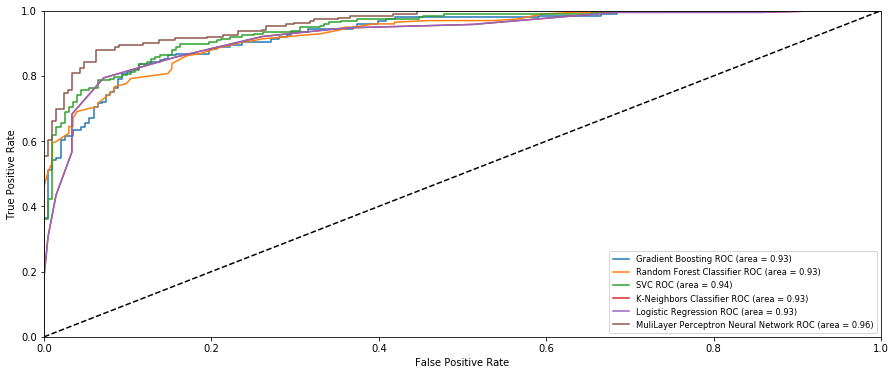

In [18]:
# ROC
roc_train_all, roc_test_all, roc_train_all_class, roc_test_all_class = model_selection.train_test_split(numeric_data, target, test_size=0.25) 
roc_train_best, roc_test_best, roc_train_best_class, roc_test_best_class = model_selection.train_test_split(numeric_data_best, target, test_size=0.25) 

models = [
    {
        'label' : 'Gradient Boosting',
        'model': model_gb,
        'roc_train': roc_train_best,
        'roc_test': roc_test_best,
        'roc_train_class': roc_train_best_class,        
        'roc_test_class': roc_test_best_class,                
    },
    {
        'label' : 'Random Forest Classifier',
        'model': model_rfc,
        'roc_train': roc_train_best,
        'roc_test': roc_test_best,
        'roc_train_class': roc_train_best_class,        
        'roc_test_class': roc_test_best_class,        
    },
        {
        'label' : 'SVC',
        'model': model_svc,
        'roc_train': roc_train_best,
        'roc_test': roc_test_best,
        'roc_train_class': roc_train_best_class,        
        'roc_test_class': roc_test_best_class,        
    },        
    {
        'label' : 'K-Neighbors Classifier',
        'model': model_knc,
        'roc_train': roc_train_all,
        'roc_test': roc_test_all,
        'roc_train_class': roc_train_all_class,        
        'roc_test_class': roc_test_all_class,        
    },
    {
        'label' : 'Logistic Regression',
        'model': model_knc,
        'roc_train': roc_train_all,
        'roc_test': roc_test_all,
        'roc_train_class': roc_train_all_class,        
        'roc_test_class': roc_test_all_class,        
    },
    {
        'label' : 'MuliLayer Perceptron Neural Network',
        'model': clf,
        'roc_train': roc_train_all,
        'roc_test': roc_test_all,
        'roc_train_class': roc_train_all_class,        
        'roc_test_class': roc_test_all_class,        
    }            
]


plt.clf()
plt.figure(figsize=(15,6))

for m in models:
    m['model'].probability = True
    probas = m['model'].fit(m['roc_train'], m['roc_train_class']).predict_proba(m['roc_test'])
    fpr, tpr, thresholds = roc_curve(m['roc_test_class'], probas[:, 1])
    roc_auc  = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], roc_auc))


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='small')
plt.show()

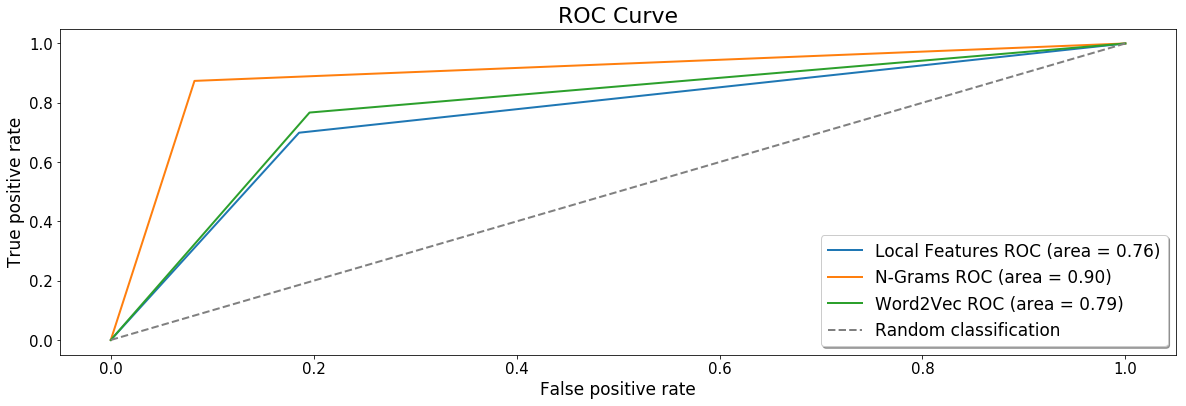

In [19]:
import grim as gr
df_roc = pd.DataFrame.from_csv("roc_table.csv")
y_true, y_pred = gr.be_ready(df_roc)
gr.plot_roc_curve_grimaldi(y_true, y_pred, label = ["Local Features", "N-Grams", "Word2Vec"])